# Fine-Tuning
So instead of feeding my data to an LLM and posing a security risk - 
I am training a small language model - [Phi3](https://azure.microsoft.com/en-us/blog/introducing-phi-3-redefining-whats-possible-with-slms/) using a custom training data I created. This custom model will produce a Cypher query based on a natural language questions.

- A `Cypher Query` is like an `SQL Query` - you can tap into the graph database using `Cypher`. This fine-tuned model will produce `Cypher` queries to tap into the database and get the relevant data

This notebook leverages Unsloth to deploy the model on hugging face and to also use this model in my own chatbot.

In [1]:
# !pip install --upgrade pip
# !pip install "unsloth[colab] @ git+https://github.com/unslothai/unsloth.git"
# !pip install matplotlib seaborn dotenv
from unsloth import FastLanguageModel
import torch
import os 
import pandas as pd
import os
from datasets import Dataset
from trl import SFTTrainer
from transformers import TrainingArguments
import time
from dotenv import load_dotenv
import os
load_dotenv()


🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.


False

# GPU for Training

Training language models require extensive compute capacity. Here are 2 great sources to access GPUs for free

1. Google Colab
2. Lightning.ai
   

In [2]:

os.environ['CUDA_VISIBLE_DEVICES'] = '0'
device_map = {"": torch.cuda.current_device()} if torch.cuda.is_available() else None

sequence_length_maximum = 512
weights_data_type = None
quantize_to_4bit = True

## Utilising a Pretrained model

- Get the Hugging face Access Tokens to access all open models
- We get the `model` to create my base SLM and a tokenizer. 

In [3]:
hf_token = os.getenv('HUGGING_FACE')
model, tokenizer = FastLanguageModel.from_pretrained(
  model_name = "unsloth/Phi-3-medium-4k-instruct",
  max_seq_length = sequence_length_maximum,
  dtype = weights_data_type,
  device_map=device_map,    
  load_in_4bit = quantize_to_4bit,
  token = hf_token
)

==((====))==  Unsloth 2024.8: Fast Mistral patching. Transformers = 4.43.3.
   \\   /|    GPU: Tesla T4. Max memory: 14.748 GB. Platform = Linux.
O^O/ \_/ \    Pytorch: 2.1.0+cu121. CUDA = 7.5. CUDA Toolkit = 12.1.
\        /    Bfloat16 = FALSE. FA [Xformers = 0.0.22.post7. FA2 = False]
 "-____-"     Free Apache license: http://github.com/unslothai/unsloth


model.safetensors.index.json:   0%|          | 0.00/165k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/3.97G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/3.72G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/172 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/3.14k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/293 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.84M [00:00<?, ?B/s]

You are using the default legacy behaviour of the <class 'transformers.models.llama.tokenization_llama_fast.LlamaTokenizerFast'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565 - if you loaded a llama tokenizer from a GGUF file you can ignore this message.


## Constructing the layers

In [4]:
model = FastLanguageModel.get_peft_model(
  model,
  r = 16,
  target_modules = ["q_proj", "k_proj", "down_proj", "v_proj", "o_proj",
  "up_proj", "gate_proj"],
  lora_alpha = 16,
  bias = "none",
  lora_dropout = 0,
  random_state = 3407,
  use_gradient_checkpointing = "True",
)

Unsloth 2024.8 patched 40 layers with 40 QKV layers, 40 O layers and 40 MLP layers.


## Uploading Some Training Data

In [5]:
mywd = os.getcwd()
# refer to the Ipynb to generate this file
df = pd.read_csv(mywd+'/text2cypher_gpt3.5turbo.csv')
df = df[(df['database'] == 'neo4j') &
(df['syntax_error'] == False) & (df['timeout'] == False)]
df = df[['question','cypher']]
df.rename(columns={'question': 'input','cypher':'output'}, inplace=True)
df.reset_index(drop=True, inplace=True)


## Acquiring the Schema of my Graph Database

In [6]:
myschema = pd.read_csv(mywd+'/text2cypher_schemas.csv').iloc[0,1]

## Formatting Input prompt
This input prompt is used to point the model to how my database is structured and also a samaple set of questions and answers. This will be useful to the model as it learns and gets trained on the custom data.

In [7]:
prompt = """Given are the instruction below, having an input \
that provides further context.
### Instruction:
{}
### Input:
{}
### Response:
{}"""
token_eos = tokenizer.eos_token
def format_prompt(columns):
    instructions = f"Use the below text to generate a cypher query. \
    The schema is given below:\n{myschema}"
    inps       = columns["input"]
    outs      = columns["output"]
    text_list = []
    for input, output in zip(inps, outs):
        text = prompt.format(instructions, input, output) + token_eos
        text_list.append(text)
    return { "text" : text_list, }

## Formatting Data

In [8]:
dataset = Dataset.from_pandas(df)
#Applying Above Function to my Data
dataset = dataset.map(format_prompt, batched = True)

Map:   0%|          | 0/203 [00:00<?, ? examples/s]

## Hyperparamater Tuning 

The most important aspect of the training - Each parameter has direct impacts on the models performance. 

***Quick Tip : Trainig LLM's are same as training ML models/Vision models/text models (ex transformers)***

### Challenges Faced: 

- **Time out Errors** due to lack of memory or datatype issues.
    - This can be handled by reducing the **batch size or reducing** the **length of the sentences**
- GPUs Do not need to be increased unless handling more than 1 billion parameter LLMs 

In [9]:

trainer = SFTTrainer(
    model = model,
    tokenizer = tokenizer,
    train_dataset = dataset,
    dataset_text_field = "text",
    max_seq_length = sequence_length_maximum,
    dataset_num_proc = 2,
    packing = False,
    args = TrainingArguments(
        per_device_train_batch_size = 2,
        gradient_accumulation_steps = 4,
        warmup_steps = 5,
        # max_steps = 60,
        num_train_epochs=1,
        learning_rate = 2e-4,
        fp16 = not torch.cuda.is_bf16_supported(),
        bf16 = torch.cuda.is_bf16_supported(),
        logging_steps = 1,
        optim = "adamw_8bit",
        weight_decay = 0.01,
        lr_scheduler_type = "linear",
        seed = 3407,
        output_dir = "outputs",
    ),
)

Map (num_proc=2):   0%|          | 0/203 [00:00<?, ? examples/s]

## GPU Stats before training

In [10]:
gpu_stats = torch.cuda.get_device_properties(0)
start_gpu_memory = round(torch.cuda.max_memory_reserved() / 1024 / 1024 / 1024, 3)
max_memory = round(gpu_stats.total_memory / 1024 / 1024 / 1024, 3)
print(f"GPU = {gpu_stats.name}. Max memory = {max_memory} GB.")
print(f"{start_gpu_memory} GB of memory reserved.")

GPU = Tesla T4. Max memory = 14.748 GB.
7.553 GB of memory reserved.


## Training 

In [11]:
t0 = time.time()

with torch.cuda.amp.autocast(cache_enabled=False):
    trainer_stats = trainer.train()

t1 = time.time()

total = t1-t0
print("Training Time : ", total)

==((====))==  Unsloth - 2x faster free finetuning | Num GPUs = 1
   \\   /|    Num examples = 203 | Num Epochs = 1
O^O/ \_/ \    Batch size per device = 2 | Gradient Accumulation steps = 4
\        /    Total batch size = 8 | Total steps = 25
 "-____-"     Number of trainable parameters = 65,536,000


Step,Training Loss
1,2.035400
2,2.035400
3,1.997000
4,1.828100
5,1.631600
6,1.538700
7,1.464200
8,1.363600
9,1.243900
10,1.126700


Training Time :  310.86868810653687


## GPU Stats after training

In [12]:
#@title Show final memory and time stats
used_memory = round(torch.cuda.max_memory_reserved() / 1024 / 1024 / 1024, 3)
used_memory_for_lora = round(used_memory - start_gpu_memory, 3)
used_percentage = round(used_memory         /max_memory*100, 3)
lora_percentage = round(used_memory_for_lora/max_memory*100, 3)
print(f"{trainer_stats.metrics['train_runtime']} seconds used for training.")
print(f"{round(trainer_stats.metrics['train_runtime']/60, 2)} minutes used for training.")
print(f"Peak reserved memory = {used_memory} GB.")
print(f"Peak reserved memory for training = {used_memory_for_lora} GB.")
print(f"Peak reserved memory % of max memory = {used_percentage} %.")
print(f"Peak reserved memory for training % of max memory = {lora_percentage} %.")

309.4114 seconds used for training.
5.16 minutes used for training.
Peak reserved memory = 14.332 GB.
Peak reserved memory for training = 6.779 GB.
Peak reserved memory % of max memory = 97.179 %.
Peak reserved memory for training % of max memory = 45.966 %.


## Inference

Testing my model based a custom question I have

In [13]:
t0 = time.time()

FastLanguageModel.for_inference(model)
inputs = tokenizer(
[
   prompt.format(
       f"Convert text to cypher query based on this schema: \n{myschema}",
      "What are the various countries which equipment are supplied to?",
       "",
   )
], return_tensors = "pt").to("cuda")
outputs = model.generate(**inputs, max_new_tokens = 128)
print(tokenizer.decode(outputs[0], skip_special_tokens = True))

t1 = time.time()

total = t1-t0
print("Inference Time : ", total)

Given are the instruction below, having an input that provides further context.
### Instruction:
Convert text to cypher query based on this schema: 
Node properties:
- **Product**
  - `line_item_quantity`: STRING Example: "19"
  - `pack_price`: STRING Example: "29.0"
  - `molecule_test_type`: STRING Example: "HIV, Reveal G3 Rapid HIV-1 Antibody Test"
  - `unit_of_measure_per_pack`: STRING Example: "30"
  - `shipment_number`: STRING Example: "ASN-8"
  - `pid`: INTEGER Min: 1, Max: 16
  - `item_description`: STRING Example: "HIV, Reveal G3 Rapid HIV-1 Antibody Test, 30 Tests"
  - `project_code`: STRING Example: "100-CI-T01"
  - `price_quote`: STRING Example: "Pre-PQ Process"
- **Country**
  - `name`: STRING Example: "Afghanistan"
- **Vendor**
  - `name`: STRING Example: "ABBOTT LABORATORIES (PUERTO RICO)"
- **Brand**
  - `name`: STRING Example: "Aluvia"
- **Product_Group**
  - `name`: STRING Available options: ['ACT', 'ANTM', 'ARV', 'HRDT', 'MRDT']
- **Sub_Class**
  - `name`: STRING Avai

## Saving Models 

- **Locally**
- **Pushing to HuggingFace**

In [14]:
model.save_pretrained("text2cypher_phi3_model") # Local saving
tokenizer.save_pretrained("text2cypher_phi3_model")

('text2cypher_phi3_model/tokenizer_config.json',
 'text2cypher_phi3_model/special_tokens_map.json',
 'text2cypher_phi3_model/tokenizer.model',
 'text2cypher_phi3_model/added_tokens.json',
 'text2cypher_phi3_model/tokenizer.json')

In [16]:
model.push_to_hub("abhi7991/promptFineTuning", token = hf_token)
tokenizer.push_to_hub("abhi7991/promptFineTuning", token = hf_token)

README.md:   0%|          | 0.00/5.18k [00:00<?, ?B/s]

adapter_model.safetensors:   0%|          | 0.00/262M [00:00<?, ?B/s]

No files have been modified since last commit. Skipping to prevent empty commit.


Saved model to https://huggingface.co/abhi7991/promptFineTuning


## Visualising the Trainings metrics

Lets see how well the model developed as the epochs passed. 

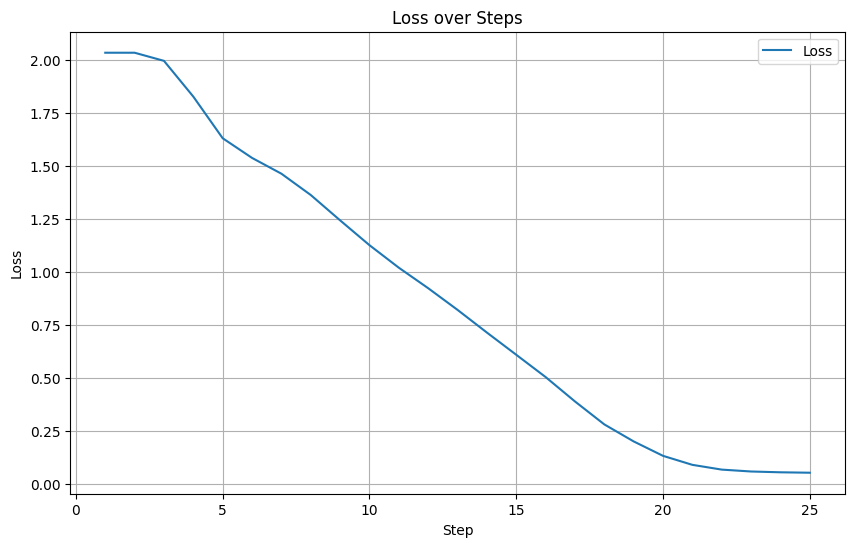

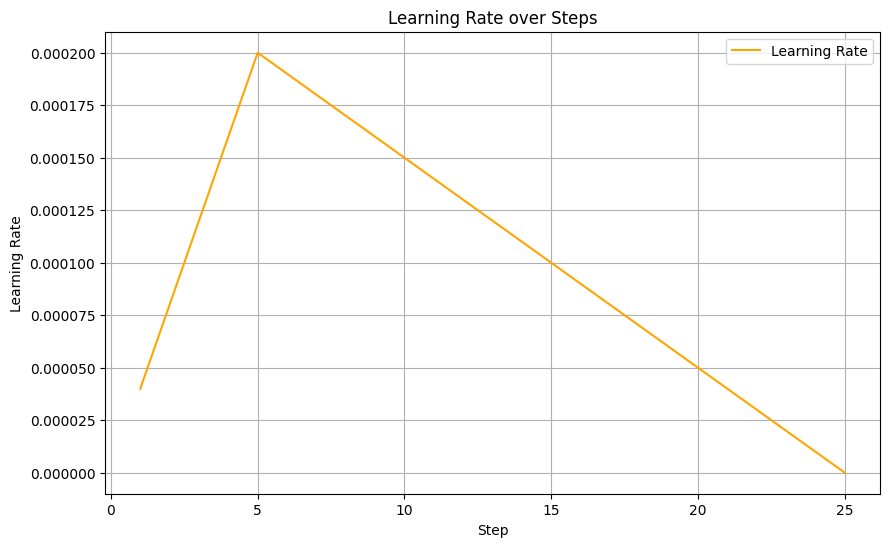

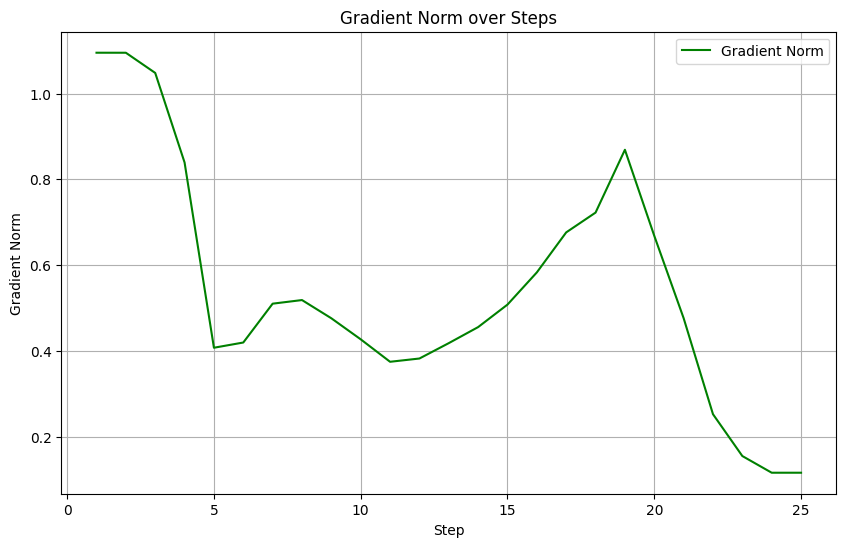

In [18]:

stats = trainer.state.log_history[:-1]

import seaborn as sns
import matplotlib.pyplot as plt

# Extract data
steps = [stat['step'] for stat in stats if 'step' in stat]
epochs = [stat['epoch'] for stat in stats if 'epoch' in stat]
loss = [stat['loss'] for stat in stats if 'loss' in stat]
learning_rate = [stat['learning_rate'] for stat in stats if 'learning_rate' in stat]
grad_norm = [stat['grad_norm'] for stat in stats if 'grad_norm' in stat]

# Plot loss over steps
plt.figure(figsize=(10, 6))
sns.lineplot(x=steps, y=loss, label='Loss')
plt.xlabel('Step')
plt.ylabel('Loss')
plt.title('Loss over Steps')
plt.legend()
plt.grid(True)
plt.savefig("Loss.png")
plt.show()

# Plot learning rate over steps
plt.figure(figsize=(10, 6))
sns.lineplot(x=steps, y=learning_rate, label='Learning Rate', color='orange')
plt.xlabel('Step')
plt.ylabel('Learning Rate')
plt.title('Learning Rate over Steps')
plt.legend()
plt.grid(True)
plt.savefig("learning_rate.png")
plt.show()

# Plot gradient norm over steps
plt.figure(figsize=(10, 6))
sns.lineplot(x=steps, y=grad_norm, label='Gradient Norm', color='green')
plt.xlabel('Step')
plt.ylabel('Gradient Norm')
plt.title('Gradient Norm over Steps')
plt.legend()
plt.grid(True)
plt.savefig("gradient.png")
plt.show()


In [19]:
# Create DataFrame
df = pd.DataFrame(trainer.state.log_history[-1],index=[0]).T.reset_index()
df.columns = ['Metric','Value']
print(df)

                     Metric         Value
0             train_runtime  3.094114e+02
1  train_samples_per_second  6.560000e-01
2    train_steps_per_second  8.100000e-02
3                total_flos  8.516571e+15
4                train_loss  8.871466e-01
5                     epoch  9.803922e-01
6                      step  2.500000e+01


## About the model and Final thoughts 

- The Loss reduces after every iteration
- Training time is significantly low
- For future scopes we can change our model to Llama or Mistral

Here is a way to access the model - https://huggingface.co/abhi7991/promptFineTuning